# Data pre-processing

In [13]:
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

In [14]:
# Load the data from the uploaded CSV file
file_path = "/content/combined_mutation_CNV.csv"
data = pd.read_csv(file_path)

# Separate the features and labels
labels = data["Subtype"].values
features = data.drop(columns=["Subtype", "Sample"]).values

# Convert to numpy arrays
labels = np.array(labels)
labels[labels=='PDM'] = 0
labels[labels=='SCM'] = 1

features = np.array(features)

# Output the results
print("Labels:", labels.shape)
print("Features:", features.shape)


Labels: (43,)
Features: (43, 656)


In [15]:
# Create a MinMaxScaler object with a feature range of -1 to 1
min_max_Scalar = preprocessing.MinMaxScaler(feature_range=(-1, 1))

# Fit the MinMaxScaler to the data (excluding the last column) and transform the data
# This scales the features to the specified range (-1 to 1)
features = min_max_Scalar.fit_transform(features)

# Convert the transformed data to a NumPy array
features = np.asarray(features)

# Encode labels if they are not integers
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# WOA

In [16]:
import numpy as np
from numpy.random import rand

import matplotlib.pyplot as plt

In [17]:
# Error rate calculation
def error_rate(x, opts, model):
    fold = opts["fold"]
    xt, yt, xv, yv = fold["xt"], fold["yt"], fold["xv"], fold["yv"]

    num_train, num_valid = xt.shape[0], xv.shape[0]
    xtrain_selected = xt[:, x == 1]
    ytrain_reshaped = yt.reshape(num_train)
    xvalid_selected = xv[:, x == 1]
    yvalid_reshaped = yv.reshape(num_valid)

    mdl = model()

    mdl.fit(xtrain_selected, ytrain_reshaped)
    ypred = mdl.predict(xvalid_selected)
    accuracy = np.sum(yvalid_reshaped == ypred) / num_valid
    return 1 - accuracy


# Cost function combining error rate and feature size
def Fun(x, opts, model):
    alpha = 0.99
    beta = 1 - alpha
    max_feat = len(x)
    num_feat = np.sum(x == 1)

    if num_feat == 0:
        return 1

    error = error_rate(x, opts, model)
    return alpha * error + beta * (num_feat / max_feat)


# Plotting the convergence curve
def plot_convergence(curve, max_iter):
    x = np.arange(1, max_iter + 1)
    plt.plot(x, curve, "o-")
    plt.xlabel("Number of Iterations")
    plt.ylabel("Fitness")
    plt.title("PSO")
    plt.grid()
    plt.show()

def init_position(lb, ub, N, dim):
    X = np.zeros([N, dim], dtype="float")
    for i in range(N):
        for d in range(dim):
            X[i, d] = lb[0, d] + (ub[0, d] - lb[0, d]) * rand()
    return X


def binary_conversion(X, thres, N, dim):
    Xbin = np.zeros([N, dim], dtype="int")
    for i in range(N):
        for d in range(dim):
            if X[i, d] > thres:
                Xbin[i, d] = 1
            else:
                Xbin[i, d] = 0
    return Xbin


def boundary(x, lb, ub):
    if x < lb:
        x = lb
    if x > ub:
        x = ub
    return x


def woa_jfs(xtrain, ytrain, opts):
    # Parameters
    ub = 1
    lb = 0
    thres = 0.5
    b = 1  # constant

    model = opts["model"]
    N = opts["N"]
    max_iter = opts["T"]
    if "b" in opts:
        b = opts["b"]

    # Dimension
    dim = np.size(xtrain, 1)
    if np.size(lb) == 1:
        ub = ub * np.ones([1, dim], dtype="float")
        lb = lb * np.ones([1, dim], dtype="float")

    # Initialize position
    X = init_position(lb, ub, N, dim)

    # Binary conversion
    Xbin = binary_conversion(X, thres, N, dim)

    # Fitness at first iteration
    fit = np.zeros([N, 1], dtype="float")
    Xgb = np.zeros([1, dim], dtype="float")
    fitG = float("inf")

    for i in range(N):
        fit[i, 0] = Fun(Xbin[i, :], opts, model)
        if fit[i, 0] < fitG:
            Xgb[0, :] = X[i, :]
            fitG = fit[i, 0]

    # Pre
    curve = np.zeros([1, max_iter], dtype="float")
    t = 0

    curve[0, t] = fitG.copy()
    print("Generation:", t + 1)
    print("Best (WOA):", curve[0, t])
    t += 1

    while t < max_iter:
        # Define a, linearly decreases from 2 to 0
        a = 2 - t * (2 / max_iter)

        for i in range(N):
            # Parameter A (2.3)
            A = 2 * a * rand() - a
            # Paramater C (2.4)
            C = 2 * rand()
            # Parameter p, random number in [0,1]
            p = rand()
            # Parameter l, random number in [-1,1]
            l = -1 + 2 * rand()
            # Whale position update (2.6)
            if p < 0.5:
                # {1} Encircling prey
                if abs(A) < 1:
                    for d in range(dim):
                        # Compute D (2.1)
                        Dx = abs(C * Xgb[0, d] - X[i, d])
                        # Position update (2.2)
                        X[i, d] = Xgb[0, d] - A * Dx
                        # Boundary
                        X[i, d] = boundary(X[i, d], lb[0, d], ub[0, d])

                # {2} Search for prey
                elif abs(A) >= 1:
                    for d in range(dim):
                        # Select a random whale
                        k = np.random.randint(low=0, high=N)
                        # Compute D (2.7)
                        Dx = abs(C * X[k, d] - X[i, d])
                        # Position update (2.8)
                        X[i, d] = X[k, d] - A * Dx
                        # Boundary
                        X[i, d] = boundary(X[i, d], lb[0, d], ub[0, d])

            # {3} Bubble-net attacking
            elif p >= 0.5:
                for d in range(dim):
                    # Distance of whale to prey
                    dist = abs(Xgb[0, d] - X[i, d])
                    # Position update (2.5)
                    X[i, d] = dist * np.exp(b * l) * np.cos(2 * np.pi * l) + Xgb[0, d]
                    # Boundary
                    X[i, d] = boundary(X[i, d], lb[0, d], ub[0, d])

        # Binary conversion
        Xbin = binary_conversion(X, thres, N, dim)

        # Fitness
        for i in range(N):
            fit[i, 0] = Fun(Xbin[i, :], opts, model)
            if fit[i, 0] < fitG:
                Xgb[0, :] = X[i, :]
                fitG = fit[i, 0]

        # Store result
        curve[0, t] = fitG.copy()
        print("Generation:", t + 1)
        print("Best (WOA):", curve[0, t])
        t += 1

    # Best feature subset
    Gbin = binary_conversion(Xgb, thres, 1, dim)
    Gbin = Gbin.reshape(dim)
    pos = np.asarray(range(0, dim))
    sel_index = pos[Gbin == 1]
    num_feat = len(sel_index)

    return {"sf": sel_index, "c": curve, "nf": num_feat}


# Helper Functions

In [18]:
import json

import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder

In [19]:
def encode_labels(labels):
    """Encode labels if they are not integers."""
    label_encoder = LabelEncoder()
    return label_encoder.fit_transform(labels)

def perform_k_fold_cv(features, labels_encoded, best_params, model):
    """Perform k-fold cross-validation with the best parameters and return results."""
    skf = StratifiedKFold(n_splits=5)
    accuracies = []
    all_classification_reports = []
    all_confusion_matrices = []

    for train_index, test_index in skf.split(features, labels_encoded):
        x_train_fold, x_test_fold = features[train_index], features[test_index]
        y_train_fold, y_test_fold = (
            labels_encoded[train_index],
            labels_encoded[test_index],
        )

        model_fold = model(**best_params)
        model_fold.fit(x_train_fold, y_train_fold)

        y_pred_fold = model_fold.predict(x_test_fold)
        accuracy_fold = metrics.accuracy_score(y_test_fold, y_pred_fold) * 100
        accuracies.append(accuracy_fold)

        classification_report_fold = classification_report(
            y_test_fold, y_pred_fold, output_dict=True
        )
        all_classification_reports.append(classification_report_fold)

        confusion_matrix_fold = confusion_matrix(y_test_fold, y_pred_fold)
        all_confusion_matrices.append(confusion_matrix_fold)

    return accuracies, all_classification_reports, all_confusion_matrices


def compute_average_classification_report(all_classification_reports):
    """Compute the average classification report."""
    return {
        key: {
            "precision": np.mean(
                [cr[key]["precision"] for cr in all_classification_reports]
            ),
            "recall": np.mean([cr[key]["recall"] for cr in all_classification_reports]),
            "f1-score": np.mean(
                [cr[key]["f1-score"] for cr in all_classification_reports]
            ),
            "support": np.mean(
                [cr[key]["support"] for cr in all_classification_reports]
            ),
        }
        for key in all_classification_reports[0].keys()
        if key != "accuracy"
    }


def plot_average_classification_report(average_classification_report):
    """Plot the average classification report."""
    categories = list(average_classification_report.keys())
    precision = [average_classification_report[cat]["precision"] for cat in categories]
    recall = [average_classification_report[cat]["recall"] for cat in categories]
    f1_score = [average_classification_report[cat]["f1-score"] for cat in categories]

    x = np.arange(len(categories))  # the label locations
    width = 0.25  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width, precision, width, label="Precision")
    rects2 = ax.bar(x, recall, width, label="Recall")
    rects3 = ax.bar(x + width, f1_score, width, label="F1-Score")

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel("Scores")
    ax.set_title("Average Classification Report by Category")
    ax.set_xticks(x)
    ax.set_xticklabels(categories, rotation=45)
    ax.legend()

    fig.tight_layout()
    plt.show()


def plot_average_confusion_matrix(all_confusion_matrices):
    """Plot the average confusion matrix."""
    average_confusion_matrix = np.mean(all_confusion_matrices, axis=0)
    disp = ConfusionMatrixDisplay(confusion_matrix=average_confusion_matrix.astype(int))
    disp.plot()
    plt.show()


def main(features, labels, param_grid, model, feature_namse):
    # Encode labels if necessary
    labels_encoded = encode_labels(labels)

    # Data preparation and PSO execution
    # xtrain, xtest, ytrain, ytest = train_test_split(
    #     features, labels_encoded, test_size=0.2, stratify=labels_encoded
    # )

    # fold = {"xt": xtrain, "yt": ytrain, "xv": xtest, "yv": ytest}

    fold = {"xt": features, "yt": labels_encoded, "xv": features, "yv": labels_encoded}

    opts = {
        "model": model,
        "N": 100,  # Number of whales
        "T": 100,  # Number of iterations
        "fold": fold
    }

    fmdl = woa_jfs(features, labels_encoded, opts)

    print("Selected Features:", fmdl["sf"])
    print("Feature Size:", fmdl["nf"])

    # Plot convergence
    plot_convergence(fmdl["c"][0], opts["T"])


    data = features[:, fmdl["sf"]]

    # Perform Grid Search to find the best parameters
    grid_search = GridSearchCV(
        model(), param_grid, cv=StratifiedKFold(n_splits=5), scoring="accuracy"
    )

    grid_search.fit(data, labels_encoded)
    best_params = grid_search.best_params_

    print("Best parameters found by GridSearchCV: ", best_params)

    # Perform k-fold cross-validation
    accuracies, all_classification_reports, all_confusion_matrices = perform_k_fold_cv(
        data, labels_encoded, best_params, model
    )

    # Print average accuracy
    mean_accuracy = np.mean(accuracies)
    print("Mean accuracy over all folds: {:.2f}%".format(mean_accuracy))

    # Compute and print average classification report
    average_classification_report = compute_average_classification_report(
        all_classification_reports
    )
    print(
        "Average Classification Report:\n",
        json.dumps(average_classification_report, indent=4),
    )

    # Plot average confusion matrix
    plot_average_confusion_matrix(all_confusion_matrices)

    # Plot average classification report
    plot_average_classification_report(average_classification_report)

    return mean_accuracy, feature_namse[np.sort(fmdl["sf"])].to_list()



# Support Vector Machines (SVM)

In [20]:
import warnings

from sklearn.svm import SVC


Generation: 1
Best (WOA): 0.0050000000000000044
Generation: 2
Best (WOA): 0.0027896341463414663
Generation: 3
Best (WOA): 0.0020121951219512213
Generation: 4
Best (WOA): 0.001996951219512197
Generation: 5
Best (WOA): 0.001996951219512197
Generation: 6
Best (WOA): 0.001996951219512197
Generation: 7
Best (WOA): 0.0019817073170731725
Generation: 8
Best (WOA): 0.0019817073170731725
Generation: 9
Best (WOA): 0.0019817073170731725
Generation: 10
Best (WOA): 0.0019817073170731725
Generation: 11
Best (WOA): 0.0019817073170731725
Generation: 12
Best (WOA): 0.0019817073170731725
Generation: 13
Best (WOA): 0.001509146341463416
Generation: 14
Best (WOA): 0.001356707317073172
Generation: 15
Best (WOA): 0.001356707317073172
Generation: 16
Best (WOA): 0.0013414634146341475
Generation: 17
Best (WOA): 0.0013414634146341475
Generation: 18
Best (WOA): 0.0013414634146341475
Generation: 19
Best (WOA): 0.0013414634146341475
Generation: 20
Best (WOA): 0.0013414634146341475
Generation: 21
Best (WOA): 0.001341

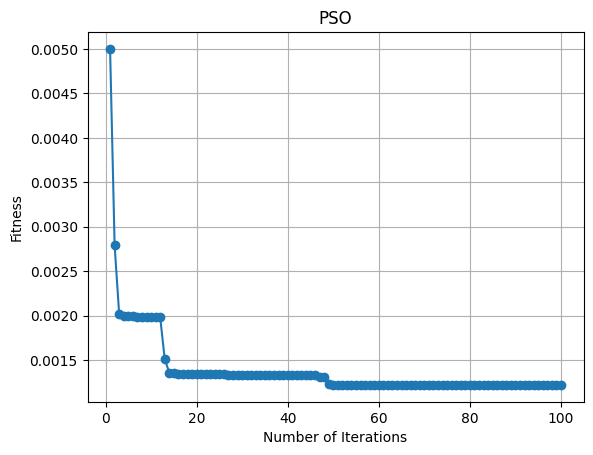

Best parameters found by GridSearchCV:  {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Mean accuracy over all folds: 55.28%
Average Classification Report:
 {
    "0": {
        "precision": 0.5142857142857142,
        "recall": 0.55,
        "f1-score": 0.5035497835497835,
        "support": 4.0
    },
    "1": {
        "precision": 0.6276190476190476,
        "recall": 0.55,
        "f1-score": 0.5486291486291487,
        "support": 4.6
    },
    "macro avg": {
        "precision": 0.570952380952381,
        "recall": 0.55,
        "f1-score": 0.5260894660894662,
        "support": 8.6
    },
    "weighted avg": {
        "precision": 0.5765079365079365,
        "recall": 0.5527777777777778,
        "f1-score": 0.5297931697931698,
        "support": 8.6
    }
}


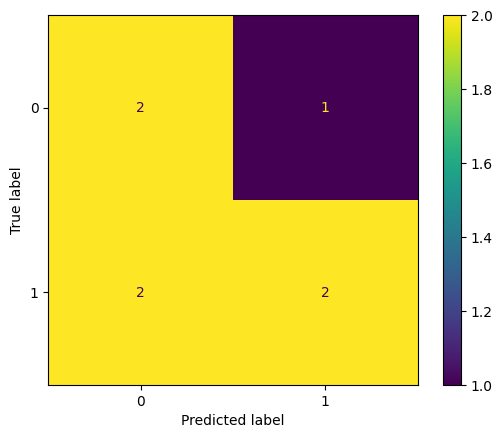

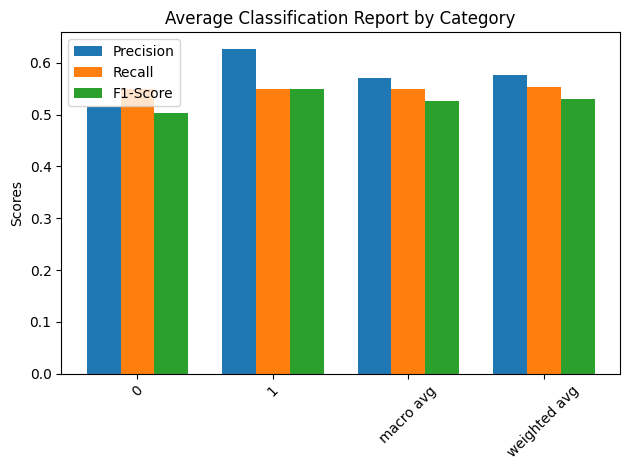

(55.27777777777777,
 ['ALK_Missense_Mutation',
  'LRP1B_Missense_Mutation',
  'CTLA4_Missense_Mutation',
  'BCL6_Missense_Mutation',
  'PRDM1_Missense_Mutation',
  'BRCA1_Missense_Mutation',
  'IL7R_Missense_Mutation',
  'RANBP2_Missense_Mutation',
  'NOTCH1_Missense_Mutation',
  'KMT2A_Missense_Mutation',
  'IRS2_Missense_Mutation',
  'AR_Missense_Mutation',
  'FAT1_Missense_Mutation',
  'CYLD_Missense_Mutation',
  'PLCG2_Missense_Mutation',
  'FAS_Missense_Mutation',
  'ERRFI1_logCR',
  'MPL_logCR',
  'JAK1_logCR',
  'BCL10_logCR',
  'HSD3B1_logCR',
  'NTRK1_logCR',
  'IL10_logCR',
  'H3F3A_logCR',
  'PARP1_logCR',
  'MEN1_logCR',
  'RPS6KB2_logCR',
  'YAP1_logCR',
  'FGF23_logCR',
  'ACVR1B_logCR',
  'ERBB3_logCR',
  'NAB2_logCR',
  'HNF1A_logCR',
  'CDK8_logCR',
  'FLT3_logCR',
  'IRS2_logCR',
  'TSHR_logCR',
  'NUTM1_logCR',
  'MAP2K1_logCR',
  'FANCI_logCR',
  'PRSS8_logCR',
  'NCOR1_logCR',
  'FLCN_logCR',
  'NF1_logCR',
  'ETV4_logCR',
  'RAD51C_logCR',
  'SRSF2_logCR',
  'YES1

In [21]:
# Suppress all warnings
warnings.filterwarnings("ignore")

param_grid = {
    "C": [0.1, 1, 10, 100],
    "kernel": ["linear", "rbf", "poly"],
    "gamma": ["scale", "auto"],
}

main(features, labels, param_grid, SVC, data.columns[2:])


# k-Nearest Neighbors (k-NN)

In [22]:
import warnings

from sklearn.neighbors import KNeighborsClassifier

Generation: 1
Best (WOA): 0.11993335224049914
Generation: 2
Best (WOA): 0.09512655984117986
Generation: 3
Best (WOA): 0.07196610890527512
Generation: 4
Best (WOA): 0.048668462847419144
Generation: 5
Best (WOA): 0.048668462847419144
Generation: 6
Best (WOA): 0.04865321894498012
Generation: 7
Best (WOA): 0.048637975042541096
Generation: 8
Best (WOA): 0.048637975042541096
Generation: 9
Best (WOA): 0.048637975042541096
Generation: 10
Best (WOA): 0.048637975042541096
Generation: 11
Best (WOA): 0.048637975042541096
Generation: 12
Best (WOA): 0.048637975042541096
Generation: 13
Best (WOA): 0.048637975042541096
Generation: 14
Best (WOA): 0.048637975042541096
Generation: 15
Best (WOA): 0.048637975042541096
Generation: 16
Best (WOA): 0.048637975042541096
Generation: 17
Best (WOA): 0.048637975042541096
Generation: 18
Best (WOA): 0.048637975042541096
Generation: 19
Best (WOA): 0.048637975042541096
Generation: 20
Best (WOA): 0.048637975042541096
Generation: 21
Best (WOA): 0.048637975042541096
Gener

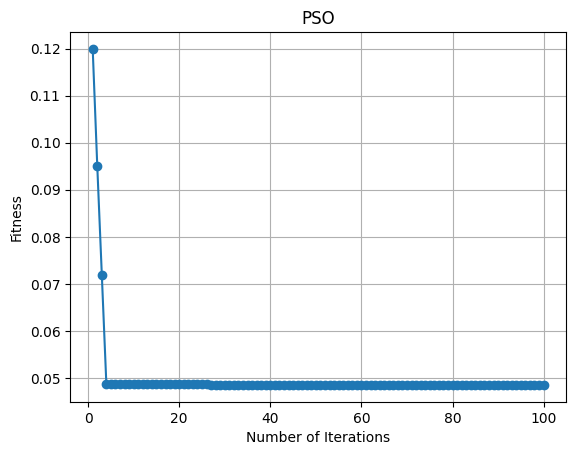

Best parameters found by GridSearchCV:  {'n_neighbors': 4}
Mean accuracy over all folds: 73.89%
Average Classification Report:
 {
    "0": {
        "precision": 0.6857142857142857,
        "recall": 0.9,
        "f1-score": 0.7757575757575756,
        "support": 4.0
    },
    "1": {
        "precision": 0.75,
        "recall": 0.5900000000000001,
        "f1-score": 0.6603174603174603,
        "support": 4.6
    },
    "macro avg": {
        "precision": 0.7178571428571429,
        "recall": 0.745,
        "f1-score": 0.7180375180375179,
        "support": 8.6
    },
    "weighted avg": {
        "precision": 0.7239682539682539,
        "recall": 0.7388888888888888,
        "f1-score": 0.7180375180375179,
        "support": 8.6
    }
}


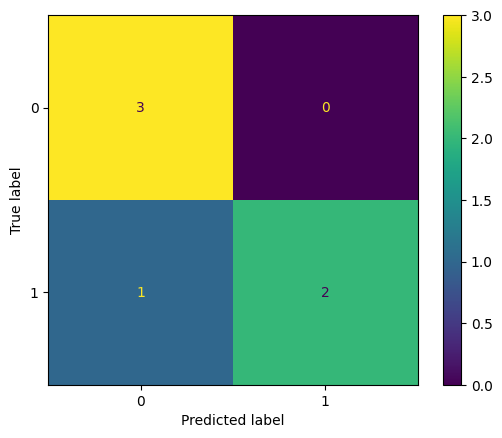

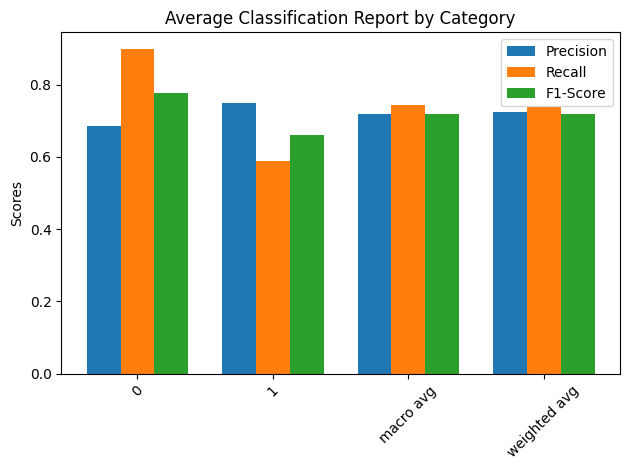

(73.88888888888889,
 ['MAP3K1_Missense_Mutation',
  'PIK3CG_Missense_Mutation',
  'PTPRD_Missense_Mutation',
  'NTRK2_Missense_Mutation',
  'SYK_Missense_Mutation',
  'KDM5A_Missense_Mutation',
  'PIK3C2G_Missense_Mutation',
  'DNMT1_Missense_Mutation',
  'PAK7_Missense_Mutation',
  'LZTR1_Missense_Mutation',
  'TFE3_Missense_Mutation',
  'PBRM1_Missense_Mutation',
  'IL7R_Missense_Mutation',
  'PAX7_Missense_Mutation',
  'RANBP2_Missense_Mutation',
  'PAX8_Missense_Mutation',
  'APC_Missense_Mutation',
  'NSD1_Missense_Mutation',
  'FLT4_Missense_Mutation',
  'IKZF1_Missense_Mutation',
  'FGF19_Missense_Mutation',
  'LATS2_Missense_Mutation',
  'IRS2_Missense_Mutation',
  'ZFHX3_Missense_Mutation',
  'ASXL1_Missense_Mutation',
  'ATRX_Missense_Mutation',
  'IDH1_Missense_Mutation',
  'GPR124_Missense_Mutation',
  'TET2_Missense_Mutation',
  'NOTCH2_Missense_Mutation',
  'PPARG_Missense_Mutation',
  'GATA1_Missense_Mutation',
  'EPHA3_Missense_Mutation',
  'CYLD_Missense_Mutation',
  '

In [23]:
# Suppress all warnings
warnings.filterwarnings("ignore")

param_grid = {"n_neighbors": np.arange(2, 10)}

main(features, labels, param_grid, KNeighborsClassifier, data.columns[2:])

# Logistic Regression

In [24]:
import warnings

from sklearn.linear_model import LogisticRegression

In [ ]:
# Suppress all warnings
warnings.filterwarnings("ignore")

param_grid = {"C": [0.01, 0.1, 1, 10, 100], "solver": ["lbfgs", "liblinear"]}

main(features, labels, param_grid, LogisticRegression, data.columns[2:])

# Decision Trees

In [25]:
import warnings

from sklearn.tree import DecisionTreeClassifier

In [ ]:
# Suppress all warnings
warnings.filterwarnings("ignore")

param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 10, 20, 30, 40, 50],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

main(features, labels, param_grid, DecisionTreeClassifier, data.columns[2:])

# Random Forest

In [26]:
import warnings

from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Suppress all warnings
warnings.filterwarnings("ignore")

param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "bootstrap": [True, False]
}

main(features, labels, param_grid, RandomForestClassifier, data.columns[2:])

# XGBoost

In [27]:
import warnings

import xgboost as xgb

In [ ]:
# Suppress all warnings
warnings.filterwarnings("ignore")

# Define the model
xgb_model = xgb.XGBClassifier
xgb_model.objective='binary:logistic'

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

main(features, labels, param_grid, xgb_model, data.columns[2:])

# All Info

In [29]:
import warnings

import xgboost as xgb

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

Generation: 1
Best (WOA): 0.004771341463414638
Generation: 2
Best (WOA): 0.0028658536585365875
Generation: 3
Best (WOA): 0.0017835365853658552
Generation: 4
Best (WOA): 0.0016768292682926844
Generation: 5
Best (WOA): 0.0014024390243902454
Generation: 6
Best (WOA): 0.0012957317073170743
Generation: 7
Best (WOA): 0.0012957317073170743
Generation: 8
Best (WOA): 0.0011585365853658547
Generation: 9
Best (WOA): 0.0011585365853658547
Generation: 10
Best (WOA): 0.0011585365853658547
Generation: 11
Best (WOA): 0.0011585365853658547
Generation: 12
Best (WOA): 0.0011585365853658547
Generation: 13
Best (WOA): 0.0011585365853658547
Generation: 14
Best (WOA): 0.0011585365853658547
Generation: 15
Best (WOA): 0.0011585365853658547
Generation: 16
Best (WOA): 0.0011585365853658547
Generation: 17
Best (WOA): 0.0011585365853658547
Generation: 18
Best (WOA): 0.0011585365853658547
Generation: 19
Best (WOA): 0.0011585365853658547
Generation: 20
Best (WOA): 0.0011585365853658547
Generation: 21
Best (WOA): 0.0

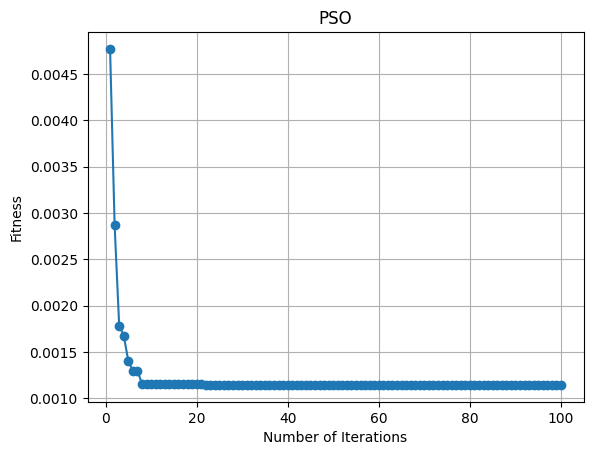

Best parameters found by GridSearchCV:  {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
Mean accuracy over all folds: 66.94%
Average Classification Report:
 {
    "0": {
        "precision": 0.7333333333333333,
        "recall": 0.6,
        "f1-score": 0.6412698412698411,
        "support": 4.0
    },
    "1": {
        "precision": 0.65,
        "recall": 0.7300000000000001,
        "f1-score": 0.6777489177489177,
        "support": 4.6
    },
    "macro avg": {
        "precision": 0.6916666666666667,
        "recall": 0.665,
        "f1-score": 0.6595093795093795,
        "support": 8.6
    },
    "weighted avg": {
        "precision": 0.6914814814814816,
        "recall": 0.6694444444444444,
        "f1-score": 0.6618181818181819,
        "support": 8.6
    }
}


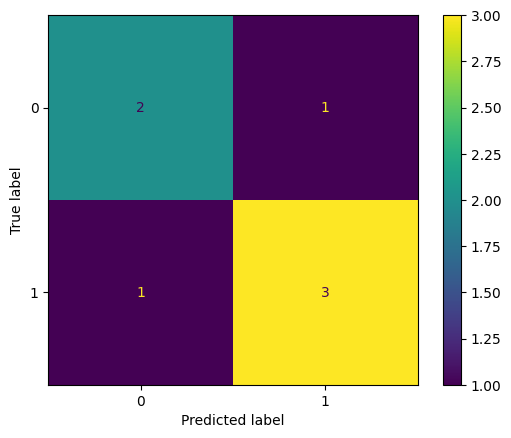

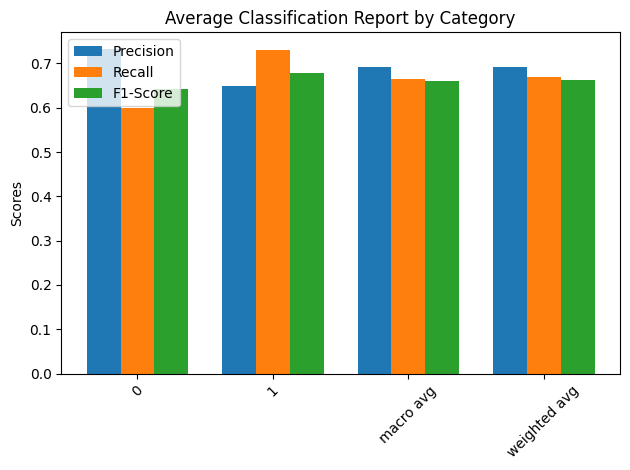

Generation: 1
Best (WOA): 0.11979615711854792
Generation: 2
Best (WOA): 0.09787046228020425
Generation: 3
Best (WOA): 0.0968338769143506
Generation: 4
Best (WOA): 0.07399354792966537
Generation: 5
Best (WOA): 0.0738868406125922
Generation: 6
Best (WOA): 0.0738868406125922
Generation: 7
Best (WOA): 0.0738868406125922
Generation: 8
Best (WOA): 0.07280452353942146
Generation: 9
Best (WOA): 0.07278927963698244
Generation: 10
Best (WOA): 0.07278927963698244
Generation: 11
Best (WOA): 0.07278927963698244
Generation: 12
Best (WOA): 0.07277403573454341
Generation: 13
Best (WOA): 0.07277403573454341
Generation: 14
Best (WOA): 0.07277403573454341
Generation: 15
Best (WOA): 0.07277403573454341
Generation: 16
Best (WOA): 0.07277403573454341
Generation: 17
Best (WOA): 0.07277403573454341
Generation: 18
Best (WOA): 0.07277403573454341
Generation: 19
Best (WOA): 0.07277403573454341
Generation: 20
Best (WOA): 0.07277403573454341
Generation: 21
Best (WOA): 0.07277403573454341
Generation: 22
Best (WOA):

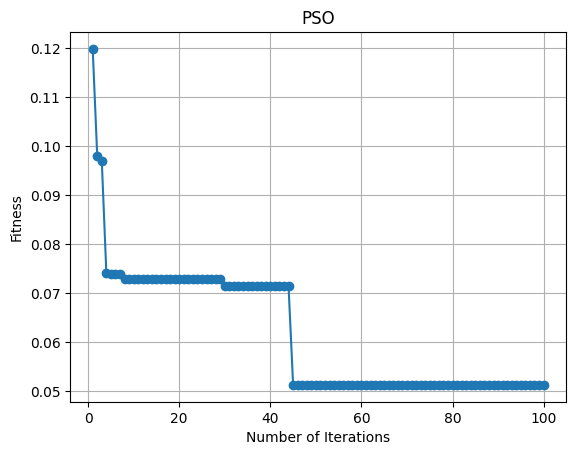

Best parameters found by GridSearchCV:  {'n_neighbors': 4}
Mean accuracy over all folds: 64.44%
Average Classification Report:
 {
    "0": {
        "precision": 0.5933333333333334,
        "recall": 1.0,
        "f1-score": 0.7377777777777778,
        "support": 4.0
    },
    "1": {
        "precision": 0.6,
        "recall": 0.32,
        "f1-score": 0.39444444444444443,
        "support": 4.6
    },
    "macro avg": {
        "precision": 0.5966666666666667,
        "recall": 0.6599999999999999,
        "f1-score": 0.5661111111111111,
        "support": 8.6
    },
    "weighted avg": {
        "precision": 0.6081481481481481,
        "recall": 0.6444444444444445,
        "f1-score": 0.5618518518518518,
        "support": 8.6
    }
}


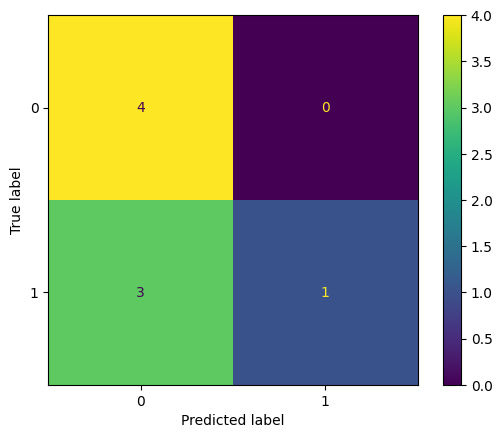

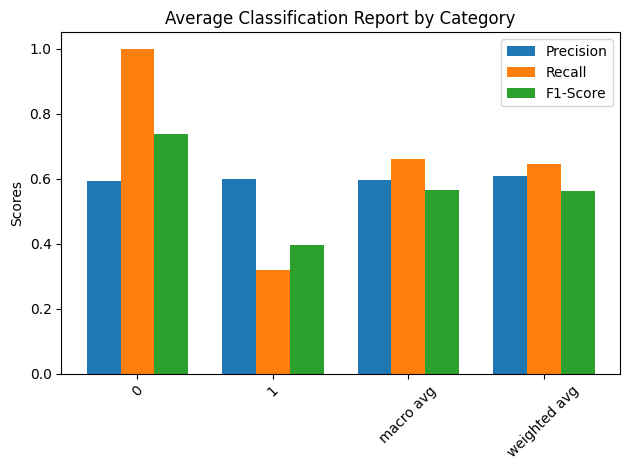

Generation: 1
Best (WOA): 0.0045884146341463455
Generation: 2
Best (WOA): 0.0011432926829268303
Generation: 3
Best (WOA): 0.0011432926829268303
Generation: 4
Best (WOA): 0.001097560975609757
Generation: 5
Best (WOA): 0.0010670731707317083
Generation: 6
Best (WOA): 0.0010670731707317083
Generation: 7
Best (WOA): 0.0010670731707317083
Generation: 8
Best (WOA): 0.0010670731707317083
Generation: 9
Best (WOA): 0.0010670731707317083
Generation: 10
Best (WOA): 0.0010670731707317083
Generation: 11
Best (WOA): 0.0010670731707317083
Generation: 12
Best (WOA): 0.0010670731707317083
Generation: 13
Best (WOA): 0.0010670731707317083
Generation: 14
Best (WOA): 0.0010670731707317083
Generation: 15
Best (WOA): 0.0010670731707317083
Generation: 16
Best (WOA): 0.0010670731707317083
Generation: 17
Best (WOA): 0.0010670731707317083
Generation: 18
Best (WOA): 0.0010670731707317083
Generation: 19
Best (WOA): 0.0010670731707317083
Generation: 20
Best (WOA): 0.0010670731707317083
Generation: 21
Best (WOA): 0.0

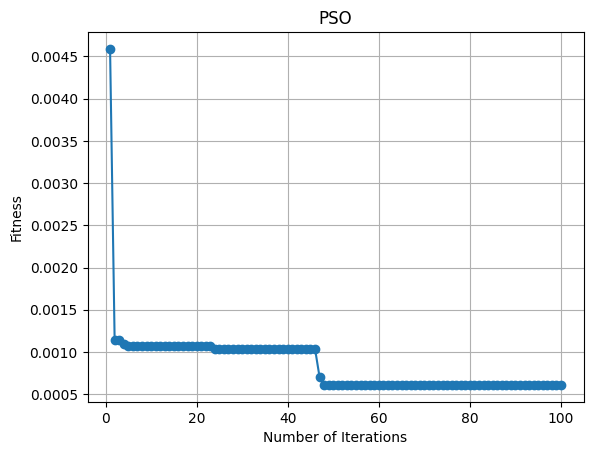

Best parameters found by GridSearchCV:  {'C': 10, 'solver': 'liblinear'}
Mean accuracy over all folds: 58.06%
Average Classification Report:
 {
    "0": {
        "precision": 0.5533333333333333,
        "recall": 0.6,
        "f1-score": 0.5542857142857143,
        "support": 4.0
    },
    "1": {
        "precision": 0.6366666666666666,
        "recall": 0.58,
        "f1-score": 0.5866666666666667,
        "support": 4.6
    },
    "macro avg": {
        "precision": 0.595,
        "recall": 0.5900000000000001,
        "f1-score": 0.5704761904761905,
        "support": 8.6
    },
    "weighted avg": {
        "precision": 0.6003703703703704,
        "recall": 0.5805555555555555,
        "f1-score": 0.5682539682539682,
        "support": 8.6
    }
}


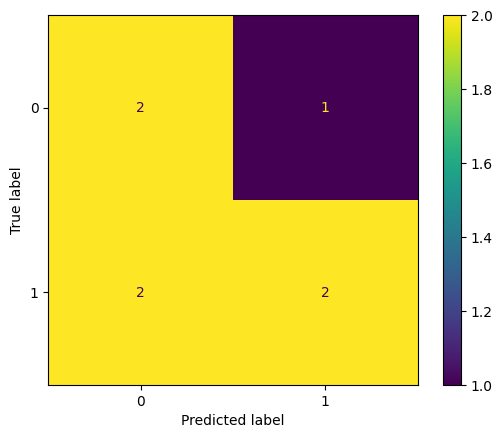

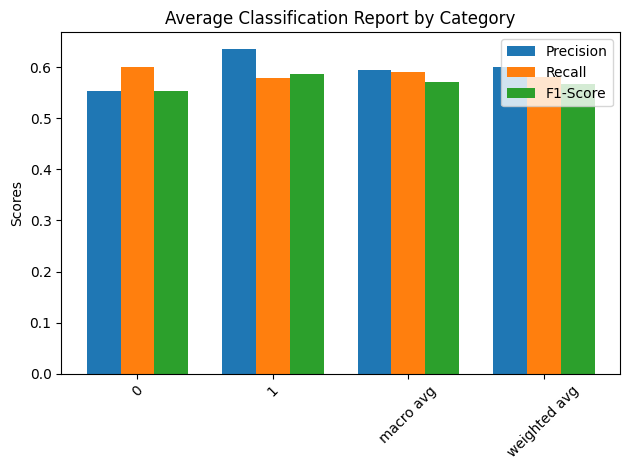

Generation: 1
Best (WOA): 0.004481707317073175
Generation: 2
Best (WOA): 6.0975609756097615e-05
Generation: 3
Best (WOA): 1.5243902439024404e-05
Generation: 4
Best (WOA): 1.5243902439024404e-05
Generation: 5
Best (WOA): 1.5243902439024404e-05
Generation: 6
Best (WOA): 1.5243902439024404e-05
Generation: 7
Best (WOA): 1.5243902439024404e-05
Generation: 8
Best (WOA): 1.5243902439024404e-05
Generation: 9
Best (WOA): 1.5243902439024404e-05
Generation: 10
Best (WOA): 1.5243902439024404e-05
Generation: 11
Best (WOA): 1.5243902439024404e-05
Generation: 12
Best (WOA): 1.5243902439024404e-05
Generation: 13
Best (WOA): 1.5243902439024404e-05
Generation: 14
Best (WOA): 1.5243902439024404e-05
Generation: 15
Best (WOA): 1.5243902439024404e-05
Generation: 16
Best (WOA): 1.5243902439024404e-05
Generation: 17
Best (WOA): 1.5243902439024404e-05
Generation: 18
Best (WOA): 1.5243902439024404e-05
Generation: 19
Best (WOA): 1.5243902439024404e-05
Generation: 20
Best (WOA): 1.5243902439024404e-05
Generation:

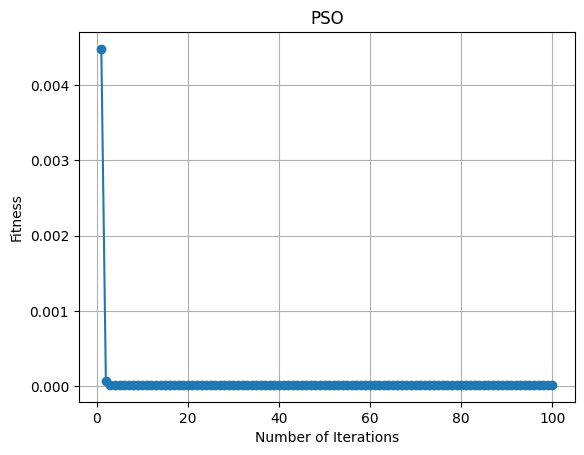

Best parameters found by GridSearchCV:  {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5}
Mean accuracy over all folds: 49.17%
Average Classification Report:
 {
    "0": {
        "precision": 0.48571428571428565,
        "recall": 0.6,
        "f1-score": 0.5233766233766234,
        "support": 4.0
    },
    "1": {
        "precision": 0.52,
        "recall": 0.41,
        "f1-score": 0.4404761904761904,
        "support": 4.6
    },
    "macro avg": {
        "precision": 0.5028571428571429,
        "recall": 0.505,
        "f1-score": 0.48192640692640687,
        "support": 8.6
    },
    "weighted avg": {
        "precision": 0.5055026455026455,
        "recall": 0.4916666666666666,
        "f1-score": 0.4762626262626263,
        "support": 8.6
    }
}


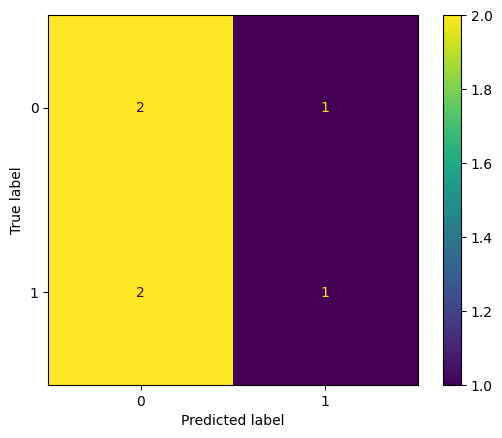

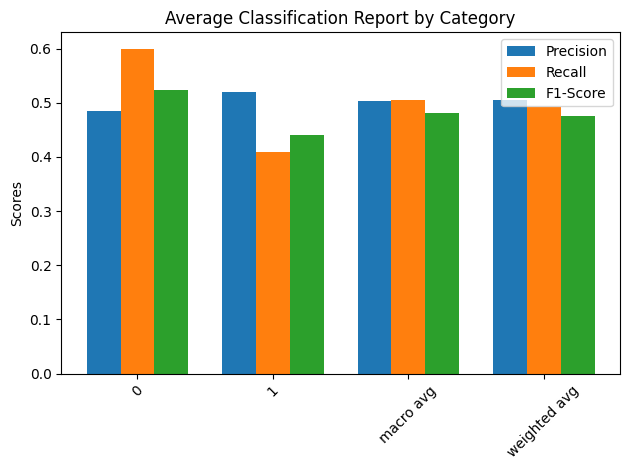

Generation: 1
Best (WOA): 0.0046646341463414676
Generation: 2
Best (WOA): 3.0487804878048808e-05
Generation: 3
Best (WOA): 3.0487804878048808e-05
Generation: 4
Best (WOA): 3.0487804878048808e-05
Generation: 5
Best (WOA): 3.0487804878048808e-05
Generation: 6
Best (WOA): 3.0487804878048808e-05
Generation: 7
Best (WOA): 3.0487804878048808e-05
Generation: 8
Best (WOA): 3.0487804878048808e-05
Generation: 9
Best (WOA): 3.0487804878048808e-05
Generation: 10
Best (WOA): 3.0487804878048808e-05
Generation: 11
Best (WOA): 3.0487804878048808e-05
Generation: 12
Best (WOA): 3.0487804878048808e-05
Generation: 13
Best (WOA): 3.0487804878048808e-05
Generation: 14
Best (WOA): 3.0487804878048808e-05
Generation: 15
Best (WOA): 3.0487804878048808e-05
Generation: 16
Best (WOA): 3.0487804878048808e-05
Generation: 17
Best (WOA): 3.0487804878048808e-05
Generation: 18
Best (WOA): 3.0487804878048808e-05
Generation: 19
Best (WOA): 3.0487804878048808e-05
Generation: 20
Best (WOA): 3.0487804878048808e-05
Generation

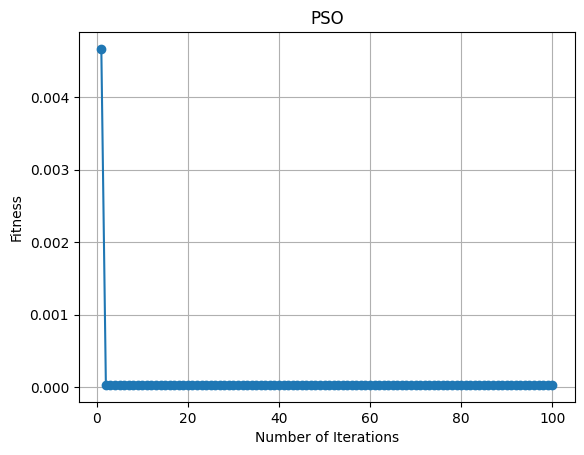

Best parameters found by GridSearchCV:  {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}
Mean accuracy over all folds: 60.56%
Average Classification Report:
 {
    "0": {
        "precision": 0.5999999999999999,
        "recall": 0.55,
        "f1-score": 0.5650793650793651,
        "support": 4.0
    },
    "1": {
        "precision": 0.6233333333333333,
        "recall": 0.66,
        "f1-score": 0.6343434343434342,
        "support": 4.6
    },
    "macro avg": {
        "precision": 0.6116666666666666,
        "recall": 0.6050000000000001,
        "f1-score": 0.5997113997113998,
        "support": 8.6
    },
    "weighted avg": {
        "precision": 0.6144444444444445,
        "recall": 0.6055555555555555,
        "f1-score": 0.6014430014430014,
        "support": 8.6
    }
}


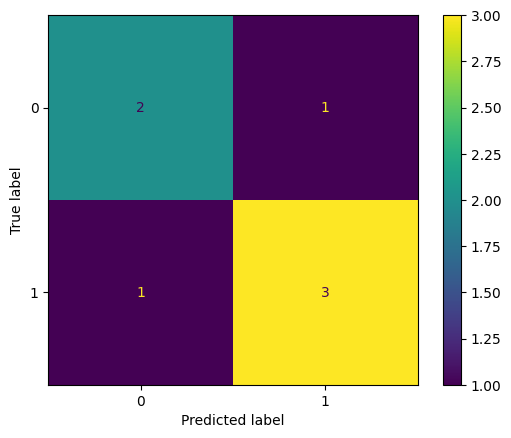

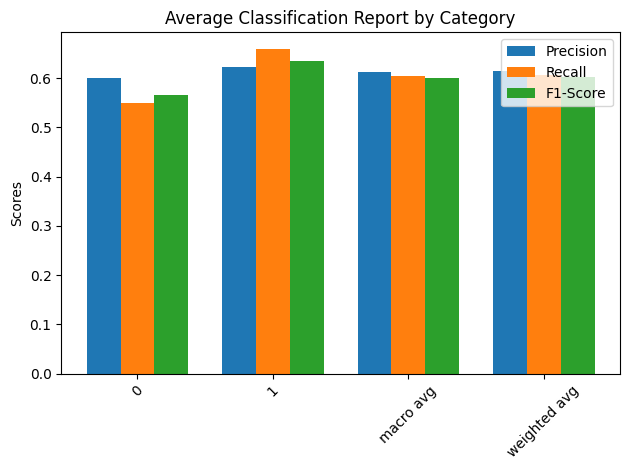

In [30]:
# Suppress all warnings
warnings.filterwarnings("ignore")

plot_results = {}
features_results = {}

param_grid = {
    "C": [0.1, 1, 10, 100],
    "kernel": ["linear", "rbf", "poly"],
    "gamma": ["scale", "auto"],
}

plot_results["SVM"], features_results["SVM"] = main(
    features, labels, param_grid, SVC, data.columns[2:]
)

param_grid = {"n_neighbors": np.arange(2, 10)}

plot_results["KNeighborsClassifier"], features_results["KNeighborsClassifier"] = main(
    features, labels, param_grid, KNeighborsClassifier, data.columns[2:]
)

param_grid = {"C": [0.01, 0.1, 1, 10, 100], "solver": ["lbfgs", "liblinear"]}

plot_results["LogisticRegression"], features_results["LogisticRegression"] = main(
    features, labels, param_grid, LogisticRegression, data.columns[2:]
)

param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 10, 20, 30, 40, 50],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}

plot_results["DecisionTreeClassifier"], features_results["DecisionTreeClassifier"] = (
    main(features, labels, param_grid, DecisionTreeClassifier, data.columns[2:])
)

# Define the model
xgb_model = xgb.XGBClassifier
xgb_model.objective='binary:logistic'

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

plot_results["XGBoost"], features_results["XGBoost"] = (
    main(features, labels, param_grid, xgb_model, data.columns[2:])
)

In [32]:
# Convert the dictionary to a pandas DataFrame
df = pd.DataFrame(list(plot_results.items()), columns=['Classifier', 'Accuracy'])

# Save DataFrame to CSV file
df.to_csv('/content/ML_WOA.csv', index=False)


In [33]:
def fix_data_length(data_dict):
    # Find the maximum length of the lists in the dictionary
    max_length = max(len(lst) for lst in data_dict.values())

    # Pad shorter lists with None
    for key, lst in data_dict.items():
        if len(lst) < max_length:
            data_dict[key] = lst + [None] * (max_length - len(lst))

    return data_dict

# Fix the data length
fixed_data = fix_data_length(features_results)

In [34]:
# Convert the dictionary to a pandas DataFrame
df = pd.DataFrame(fixed_data)
df

,SVM,KNeighborsClassifier,LogisticRegression,DecisionTreeClassifier,XGBoost
0,TMB,TMB,ERBB4_Missense_Mutation,EPHA7_logCR,PTPRT_logCR
1,PGA,PGA,ERG_Missense_Mutation,None,KEL_logCR
2,MYCN_Missense_Mutation,SPTA1_Missense_Mutation,EWSR1_Missense_Mutation,None,None
3,CTLA4_Missense_Mutation,SETD2_Missense_Mutation,NOTCH1_Missense_Mutation,None,None
4,GABRA6_Missense_Mutation,PRKDC_Missense_Mutation,LATS2_Missense_Mutation,None,None
...,...,...,...,...,...
333,None,AR_logCR,None,None,None
334,None,TAF1_logCR,None,None,None
335,None,PAK3_logCR,None,None,None
336,None,XIAP_logCR,None,None,None


In [38]:
# Extracting common features in all classifiers
common_features = set(df['SVM'])

for column in df.columns[1:]:
    common_features.intersection_update(df[column])

# Converting the set to a sorted list for better readability
common_features = sorted(list(common_features))

common_features = common_features + [None] * (338)

# Print the common features
print(common_features)

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, Non

In [39]:
len(common_features)

338

In [40]:
# Using DataFrame.insert() to add a column
df.insert(2, "Common_Features", common_features, True)

# Observe the result
print(df)

                          SVM     KNeighborsClassifier Common_Features  \
0                         TMB                      TMB            None   
1                         PGA                      PGA            None   
2      MYCN_Missense_Mutation  SPTA1_Missense_Mutation            None   
3     CTLA4_Missense_Mutation  SETD2_Missense_Mutation            None   
4    GABRA6_Missense_Mutation  PRKDC_Missense_Mutation            None   
..                        ...                      ...             ...   
333                      None                 AR_logCR            None   
334                      None               TAF1_logCR            None   
335                      None               PAK3_logCR            None   
336                      None               XIAP_logCR            None   
337                      None              STAG2_logCR            None   

           LogisticRegression DecisionTreeClassifier      XGBoost  
0     ERBB4_Missense_Mutation            EP

In [41]:
# Save DataFrame to CSV file
df.to_csv('/content/ML_WOA_features.csv', index=False)